In [106]:

import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Masking, TimeDistributed
from tensorflow.keras import mixed_precision
import shap
from sklearn.inspection import permutation_importance
import pickle
from sklearn.preprocessing import StandardScaler
from keras import backend as K

op ='win'
if op == 'win':
    path = f'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = f'~/Documents/GitHub/master-project/'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#import the X and y data in the format .npy
dataset = 'dataset_1h'

X_train = np.load(f'{path}DATASETS/X_y/X_train.npy')
y_train = np.load(f'{path}DATASETS/X_y/y_train.npy')
X_test = np.load(f'{path}DATASETS/X_y/X_test.npy')
y_test = np.load(f'{path}DATASETS/X_y/y_test.npy')
X_validation = np.load(f'{path}DATASETS/X_y/X_validation.npy')
y_validation = np.load(f'{path}DATASETS/X_y/y_validation.npy')

In [107]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0
X_validation[np.isnan(X_validation)] = 0

y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0
y_validation[np.isnan(y_validation)] = 0


def masked_mse(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    mse = K.square(y_pred - y_true)
    mse = mse * mask
    return K.sum(mse) / K.sum(mask)


In [127]:
# Define the model
model_Gia_3d = Sequential()

# Define the input shape in the first layer of the neural network
#input_shape = (X_train.shape[1], X_train.shape[2])

# Add a Conv1D layer with 32 filters and a kernel size of 3
#model_Gia.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
model_Gia_3d.add(Masking(mask_value=0., input_shape=(X_train.shape[1],X_train.shape[2])))

# Add the first LSTM layer with 128 units
model_Gia_3d.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))

# Add the second LSTM layer with 256 units
#model_Gia_2.add(LSTM(units=256))

# Add a Dense (fully connected) layer with 128 units and tanh activation
model_Gia_3d.add(Dense(units=128, activation='tanh'))

# Flatten the output
model_Gia_3d.add(Flatten())

# Add the final Dense layer with a linear activation function
# Assuming the output length is predefined, for example, 1
output_length = X_train.shape[1]

#model_Gia_3d.add(TimeDistributed(Dense(units=1, activation='linear')))
model_Gia_3d.add(Dense(units=output_length, activation='linear'))

# Compile the model
model_Gia_3d.compile(optimizer='adam', loss=masked_mse)

# Print the model summary
model_Gia_3d.summary()

ValueError: `TimeDistributed` Layer should be passed an `input_shape ` with at least 3 dimensions, received: (None, 60416)

In [124]:
run_index = 4 # it should be an integer, e.g. 1

run_logdir = os.path.join(os.curdir, "LSTM_3d_logs/", "run_{:03d}".format(run_index))

print(run_logdir)

.\LSTM_3d_logs/run_004


In [125]:
# Define callbacks (they can really improve the accuracy if well-chosen!)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_Gia_3d.keras", 
                                                   save_best_only=True,
                                                   monitor='loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [126]:
# Entraîner le modèle
model_Gia_3d.fit(X_train, y_train, 
          epochs=50, 
          verbose=1,  
          batch_size=32,
          callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],)
          #use_multiprocessing=True)

# Faire des prédictions
y_pred = model_Gia_3d.predict(X_test)

Epoch 1/50
3/3 [==============================] - 7s 248ms/step - loss: 158.7151
Epoch 2/50
3/3 [==============================] - 1s 216ms/step - loss: 71.1159
Epoch 3/50
3/3 [==============================] - 1s 222ms/step - loss: 62.1663
Epoch 4/50
3/3 [==============================] - 1s 252ms/step - loss: 44.9249
Epoch 5/50
3/3 [==============================] - 1s 224ms/step - loss: 39.0029
Epoch 6/50
3/3 [==============================] - 1s 207ms/step - loss: 43.6046
Epoch 7/50
3/3 [==============================] - 1s 218ms/step - loss: 38.4822
Epoch 8/50
3/3 [==============================] - 1s 219ms/step - loss: 35.2450
Epoch 9/50
3/3 [==============================] - 1s 198ms/step - loss: 41.1546
Epoch 10/50
3/3 [==============================] - 1s 198ms/step - loss: 36.5826
Epoch 11/50
3/3 [==============================] - 1s 199ms/step - loss: 36.2044
Epoch 12/50
3/3 [==============================] - 1s 215ms/step - loss: 34.6123
Epoch 13/50
3/3 [===================

In [ ]:

storm_n = 0
for storm_n in range(19):
    plt.plot(y_pred[storm_n,:], label='y_pred')
    plt.plot(y_test[storm_n,:], label='y_test')
    plt.legend()
    plt.show()

# calculate the RMSE

rms = (mean_squared_error(y_test,y_pred))**0.5
print(rms) 

In [132]:
# Define the model
model_2_3d = Sequential()

# Define the input shape in the first layer of the neural network
#input_shape = (X_train.shape[1], X_train.shape[2])

# Add a Conv1D layer with 32 filters and a kernel size of 3
#model_Gia.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
model_2_3d.add(Masking(mask_value=0., input_shape=X_train.shape))

# Add the first LSTM layer with 128 units
model_2_3d.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))


model_2_3d.add(TimeDistributed(Dense(units=1, activation='linear')))

# Add the second LSTM layer with 256 units
#model_Gia_2.add(LSTM(units=256))

# Add a Dense (fully connected) layer with 128 units and tanh activation
#model_2_3d.add(Dense(units=128, activation='tanh'))

# Flatten the output
#model_2_3d.add(Flatten())

# Add the final Dense layer with a linear activation function
# Assuming the output length is predefined, for example, 1
#output_length = X_train.shape[1]

#model_Gia_3d.add(Dense(units=output_length, activation='linear'))

# Compile the model
model_2_3d.compile(optimizer='adam', loss=masked_mse)

# Print the model summary
model_2_3d.summary()

TypeError: __init__() got multiple values for argument 'units'

In [155]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Dense, LSTM, Masking

# Define the input shape (storm number, time steps, variables)
input_shape = (None, 68)

# Input layer
inputs = Input(shape=input_shape)

# Optional Masking layer to handle variable length sequences
masked = Masking(mask_value=0.0)(inputs)

# TimeDistributed layer wrapped around a Dense layer
td_dense = TimeDistributed(Dense(128, activation='relu'))(masked)

# We need to reshape the TimeDistributed layer's output to match LSTM input requirements
# Reshape to (batch_size * storm_number, timesteps, features)
#reshape_td = tf.reshape(td_dense, (-1, tf.shape(td_dense)[2], 32))

# LSTM layer to handle sequential data
lstm = LSTM(128, return_sequences=True)(td_dense)

lstm_2 = LSTM(256, return_sequences=True)(lstm)

# Reshape back to (batch_size, storm_number, timesteps, features)
#reshape_lstm = tf.reshape(lstm, (-1, 67, tf.shape(lstm)[1], 64))

# Another TimeDistributed layer for final dense layer
output_td = TimeDistributed(Dense(1))(lstm_2)

# Reshape to match the output shape (67, 472)
#outputs = tf.reshape(output_td, (-1, 472))
flattened = tf.reshape(output_td, (tf.shape(inputs)[0], -1))

# Create the model
model = Model(inputs, flattened)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, 68)]   0           []                               
                                                                                                  
 masking_23 (Masking)           (None, None, 68)     0           ['input_8[0][0]']                
                                                                                                  
 time_distributed_19 (TimeDistr  (None, None, 128)   8832        ['masking_23[0][0]']             
 ibuted)                                                                                          
                                                                                                  
 lstm_25 (LSTM)                 (None, None, 128)    131584      ['time_distributed_19[0][0]

In [156]:
model.fit(X_train, y_train,
          validation_data=(X_validation, y_validation),
          epochs=50, 
          batch_size=32, 
          verbose=1)

Epoch 1/50
3/3 [==============================] - 13s 2s/step - loss: 70.0751 - val_loss: 59.0847
Epoch 2/50
3/3 [==============================] - 2s 635ms/step - loss: 31.9534 - val_loss: 88.7935
Epoch 3/50
3/3 [==============================] - 2s 582ms/step - loss: 20.6575 - val_loss: 119.1746
Epoch 4/50
3/3 [==============================] - 2s 586ms/step - loss: 15.6988 - val_loss: 92.3324
Epoch 5/50
3/3 [==============================] - 2s 589ms/step - loss: 10.9016 - val_loss: 73.8970
Epoch 6/50
3/3 [==============================] - 2s 607ms/step - loss: 8.7991 - val_loss: 84.3066
Epoch 7/50
3/3 [==============================] - 2s 593ms/step - loss: 6.4076 - val_loss: 96.7484
Epoch 8/50
3/3 [==============================] - 2s 596ms/step - loss: 5.5907 - val_loss: 104.3265
Epoch 9/50
3/3 [==============================] - 2s 594ms/step - loss: 4.8381 - val_loss: 112.4849
Epoch 10/50
3/3 [==============================] - 2s 635ms/step - loss: 4.2630 - val_loss: 132.8023
Ep

In [153]:
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


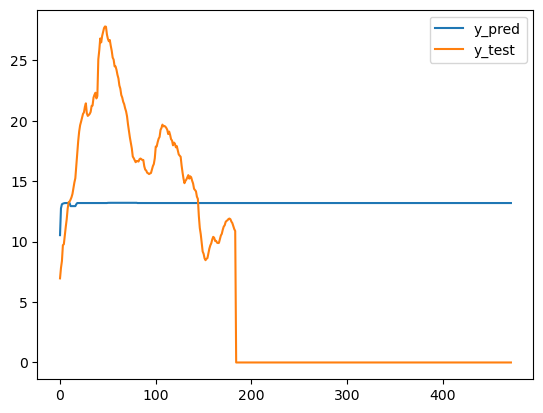

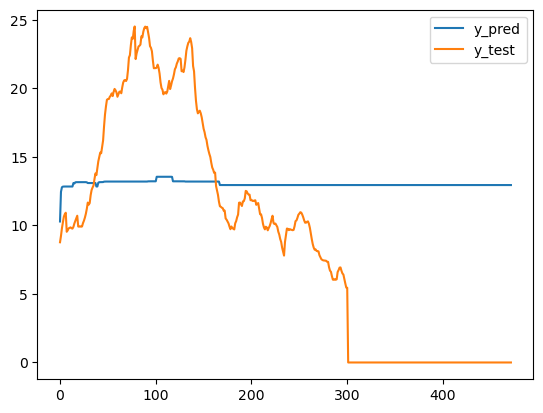

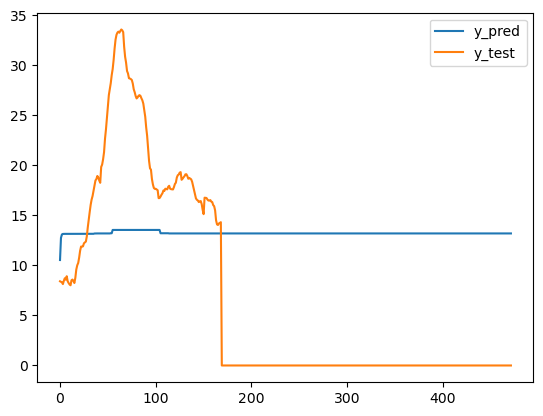

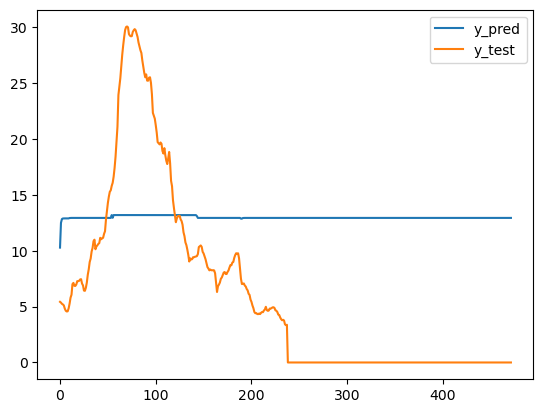

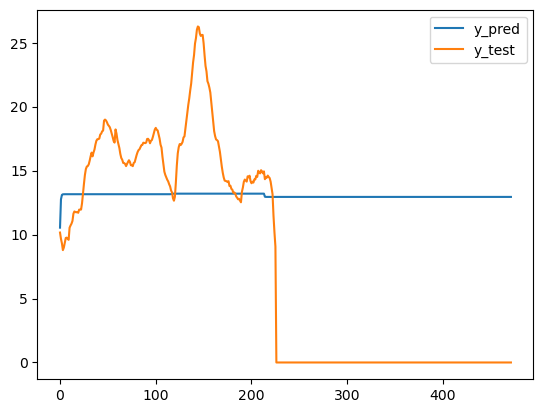

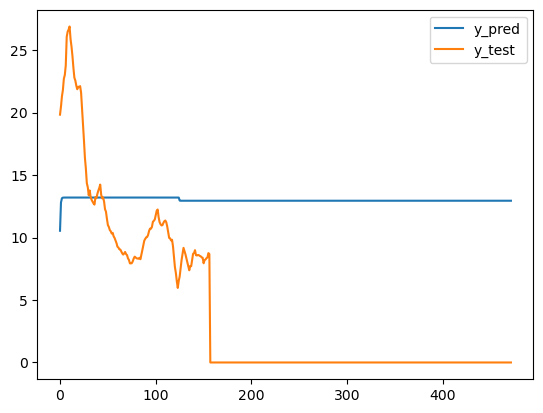

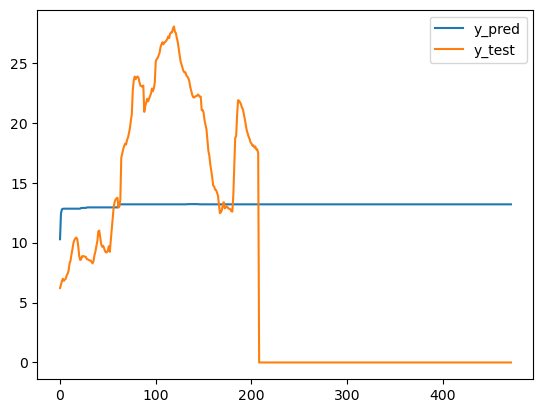

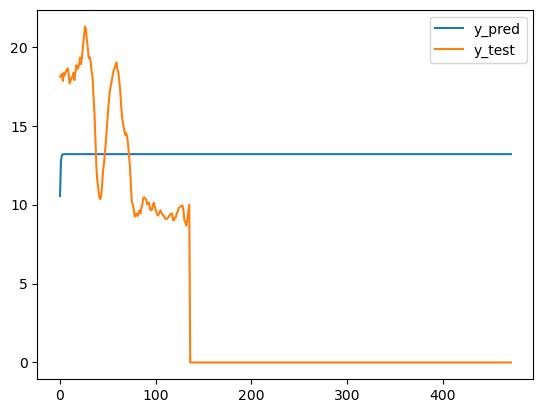

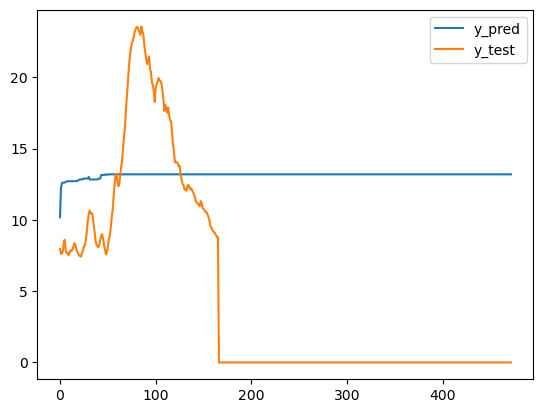

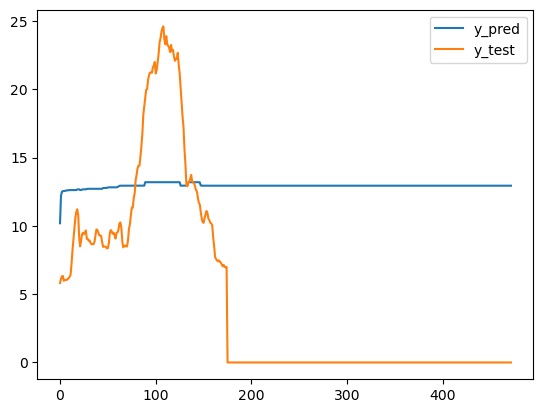

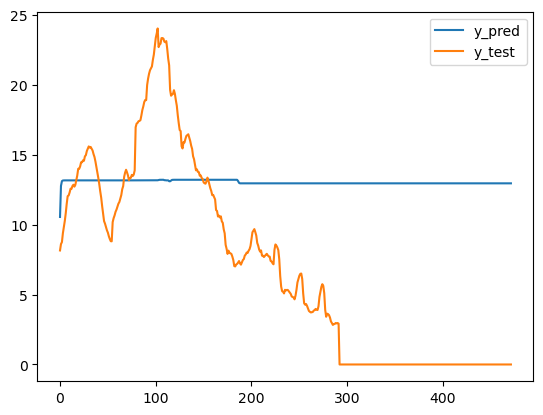

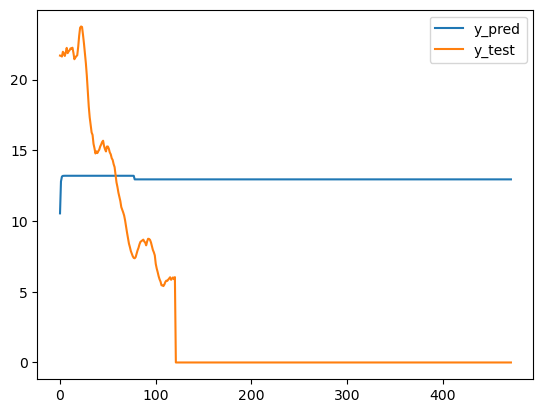

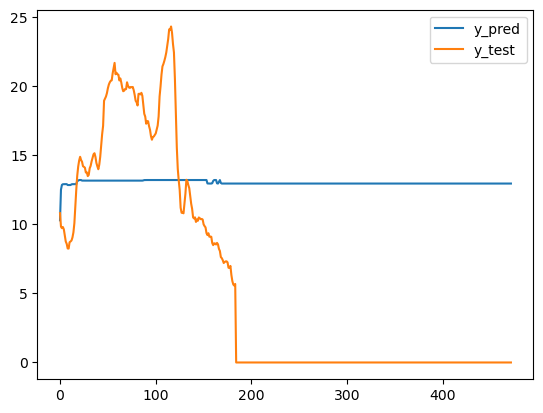

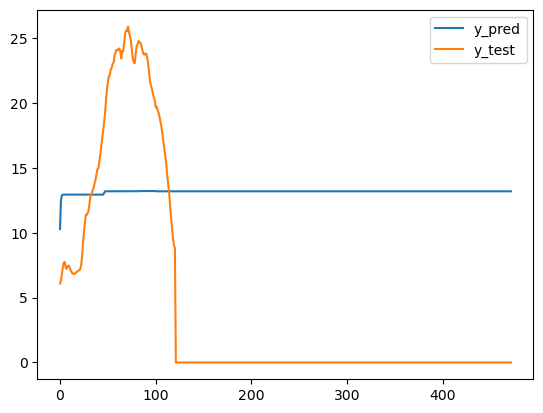

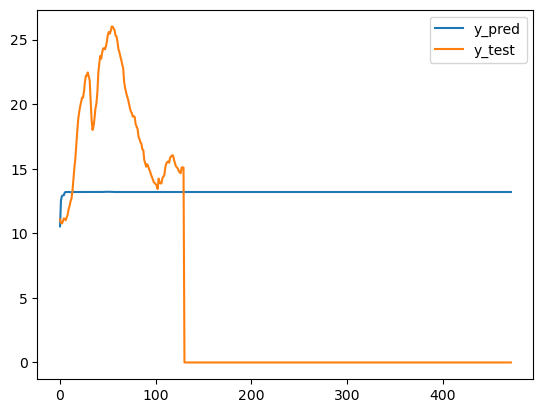

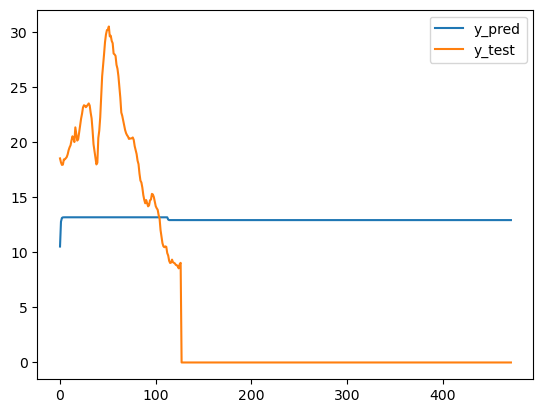

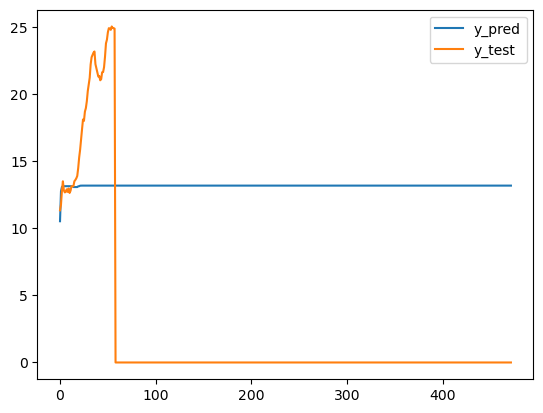

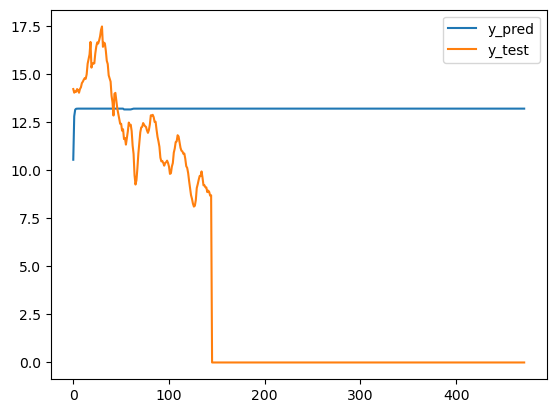

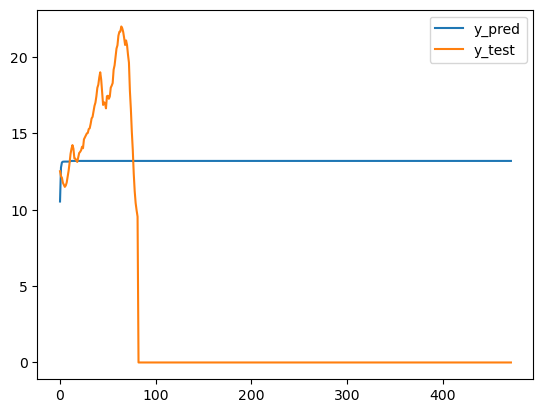

In [154]:
for storms in range(19):
    plt.plot(y_pred[storms,:], label='y_pred')
    plt.plot(y_test[storms,:], label='y_test')
    plt.legend()
    plt.show()